**Общая информация**

**Срок сдачи:** 16 марта 2020, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist
from scipy.sparse import csr_matrix

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_mldata, fetch_20newsgroups

from sklearn.neighbors import KDTree

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from sklearn.model_selection import RepeatedKFold as RKF
from sklearn.feature_extraction.text import TfidfVectorizer as tfidfvec
from sklearn.feature_extraction.text import CountVectorizer as cntvec

Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [2]:
class MyKNeighborsClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors, algorithm='brute', metric='euclidean'):
        self.neighb = n_neighbors
        self.alg = algorithm
        self.metric = metric
    
    def fit(self, X, Y):
        self.Ytrain = np.array(Y)
        if self.alg == 'brute':
            self.Xtrain = X
        elif self.alg == 'kd_tree':
            self.Xtrain = KDTree(X)
    
    def predict(self, X):
        Ypred = np.array([]).astype(int)
        if self.alg == 'brute':
            neighb_indices = cdist(X, self.Xtrain).argsort(axis = 1)[:, :self.neighb]
            
        elif self.alg == 'kd_tree':
            _, neighb_indices = self.Xtrain.query(X, k = self.neighb)
        
        neighb_arr = self.Ytrain[neighb_indices]
        for neighb in neighb_arr:
            neighb, cnt = np.unique(neighb, axis = 0, return_counts = True)
            cnt = cnt.argsort()
            Ypred = np.append(Ypred, neighb[cnt[np.size(cnt) - 1]])
        
        return Ypred

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [6]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)
my_clf.predict(X_test)

array([0, 2, 1, 2, 1, 1, 2, 0, 0, 2, 1, 0, 1, 0, 2])

In [7]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [8]:
%time clf.fit(X_train, y_train)

CPU times: user 1.5 ms, sys: 251 µs, total: 1.75 ms
Wall time: 1.34 ms


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [9]:
%time my_clf.fit(X_train, y_train)

CPU times: user 24 µs, sys: 4 µs, total: 28 µs
Wall time: 31.9 µs


In [10]:
%time clf.predict(X_test)

CPU times: user 3.85 ms, sys: 0 ns, total: 3.85 ms
Wall time: 3.09 ms


array([0, 2, 1, 2, 1, 1, 2, 0, 0, 2, 1, 0, 1, 0, 2])

In [11]:
%time my_clf.predict(X_test)

CPU times: user 6.05 ms, sys: 207 µs, total: 6.26 ms
Wall time: 5.89 ms


array([0, 2, 1, 2, 1, 1, 2, 0, 0, 2, 1, 0, 1, 0, 2])

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [12]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [13]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [14]:
%time clf.fit(X_train, y_train)

CPU times: user 4.23 ms, sys: 6 µs, total: 4.24 ms
Wall time: 4.21 ms


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [15]:
%time my_clf.fit(X_train, y_train)

CPU times: user 273 µs, sys: 45 µs, total: 318 µs
Wall time: 301 µs


In [16]:
%time clf.predict(X_test)

CPU times: user 8.38 ms, sys: 0 ns, total: 8.38 ms
Wall time: 6.19 ms


array([1, 2, 1, 0, 2, 0, 1, 2, 2, 1, 0, 0, 0, 1, 2])

In [17]:
%time my_clf.predict(X_test)

CPU times: user 6.24 ms, sys: 0 ns, total: 6.24 ms
Wall time: 4.97 ms


array([1, 2, 1, 0, 2, 0, 1, 2, 2, 1, 0, 0, 0, 1, 2])

In [32]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [3]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [4]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [5]:
vectorizer = cntvec(min_df = 10)
matrix = vectorizer.fit_transform(data)
matrix = np.array(matrix.todense())

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [20]:
folds = RKF(n_splits = 3, n_repeats = 10).split(matrix)

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [21]:
def optimal_neighb(X, Y, folds, metr = 'euclidean'):
    scores = np.array(range(10), dtype=float)
    i = 0
    score = np.array([], dtype = float)
    my_clf = MyKNeighborsClassifier(n_neighbors = 2, algorithm = 'brute', metric = metr)
    for train, test in folds:
        my_clf.fit(X[train], Y[train])
        correct = my_clf.predict(X[test]) == Y[test]
        score = np.append(score, np.average(correct))
        if i % 3 == 2:
            scores[i // 3] = np.mean(score)
            score = np.array([], dtype = float)
            my_clf = MyKNeighborsClassifier(n_neighbors = i // 3 + 3, algorithm = 'brute', metric = metr)
        i += 1
    return scores

In [ ]:
scores = optimal_neighb(matrix, target, folds)

In [11]:
for i in range(10):
    print('{} neighbors: score = {}'.format(i + 1, scores[i]))

1 neighbors: score = 0.16210057892837929
2 neighbors: score = 0.15962463626573245
3 neighbors: score = 0.16342625283331455
4 neighbors: score = 0.16943638072885867
5 neighbors: score = 0.17465000287303556
6 neighbors: score = 0.17491652027308555
7 neighbors: score = 0.17960031810549504
8 neighbors: score = 0.18092681220817952
9 neighbors: score = 0.1777442809017001
10 neighbors: score = 0.17580055284140406


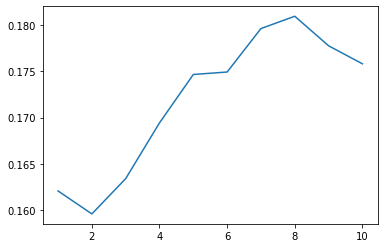

In [15]:
plt.plot(range(1, 11), scores)
plt.show()

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

In [ ]:
vectorizer2 = tfidfvec(min_df = 10)
matrix2 = vectorizer2.fit_transform(data)
matrix2 = np.array(matrix2.todense())
folds = RKF(n_splits = 3, n_repeats = 10).split(matrix2)
scores2 = optimal_neighb(matrix2, target, folds, metr = 'cosine')

In [11]:
for i in range(10):
    print('{} neighbors: score = {}'.format(i + 1, scores2[i]))

1 neighbors: score = 0.13735197891220033
2 neighbors: score = 0.125419460846056
3 neighbors: score = 0.11649282692543295
4 neighbors: score = 0.11543219406459915
5 neighbors: score = 0.11057144442635321
6 neighbors: score = 0.10968788054246285
7 neighbors: score = 0.10588645144865201
8 neighbors: score = 0.11057102261036793
9 neighbors: score = 0.10721252373535116
10 neighbors: score = 0.10685829204457864


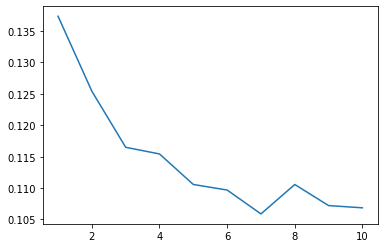

In [16]:
plt.plot(range(1, 11), scores2)
plt.show()

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [7]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])
test_data = newsgroups['data']
test_target = newsgroups['target']

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [17]:
vectorizer = tfidfvec(min_df = 10)
matrix = vectorizer.fit_transform(data)
matrix = np.array(matrix.todense())

test_matrix = vectorizer.transform(test_data)
test_matrix = np.array(test_matrix.todense())

my_clf = MyKNeighborsClassifier(n_neighbors = np.argmax(scores) + 2, algorithm = 'brute', metric = 'euclidean')
my_clf.fit(matrix, target)
correct = my_clf.predict(test_matrix) == test_target
score = np.average(correct)
print(score)

0.08510355815188529
